In [3]:
dataset_path='/kaggle/input/utkface-new/UTKFace'

In [4]:
import os
import glob
import pandas as pd

# Dataset constants and mappings
dataset_folder_name = '/kaggle/input/utkface-new/UTKFace'
IM_WIDTH = IM_HEIGHT = 198
TRAIN_TEST_SPLIT = 0.7

# Dataset mapping dictionaries
dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

# Create reverse mappings for aliases
dataset_dict['gender_alias'] = {v: k for k, v in dataset_dict['gender_id'].items()}  
dataset_dict['race_alias'] = {v: k for k, v in dataset_dict['race_id'].items()}     

# Function to parse dataset
def parse_dataset(dataset_path, ext='jpg'):
    """
    Extracts metadata (age, gender, race) from filenames and returns a DataFrame.
    Assumes filenames follow the format: age_gender_race_other.ext.
    """
    def parse_info_from_file(path):
        """
        Parse metadata from a single file path.
        """
        try:
            filename = os.path.basename(path)  # Extract file name
            filename = os.path.splitext(filename)[0]  # Remove file extension
            age, gender, race, _ = filename.split('_')  # Extract metadata
            
            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)], path
        except Exception:
            return None  # Handle invalid filenames

    # Collect all file paths
    files = glob.glob(os.path.join(dataset_path, f"*.{ext}"))
    
    # Parse each file and filter invalid entries
    records = [parse_info_from_file(file) for file in files]
    records = [record for record in records if record is not None]
    
    # Create DataFrame
    df = pd.DataFrame(records, columns=['age', 'gender', 'race', 'file'])
    return df

# Parse the dataset
df = parse_dataset(dataset_folder_name)

# Display the first few rows of the DataFrame
df.head()


,age,gender,race,file
0,26,male,asian,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...
1,22,female,black,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...
2,21,female,indian,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...
3,28,male,white,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...
4,17,female,others,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...


In [5]:
df.describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [6]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
#from keras.preprocessing.image import image_dataset_from_directory,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [7]:
import tensorflow as tf

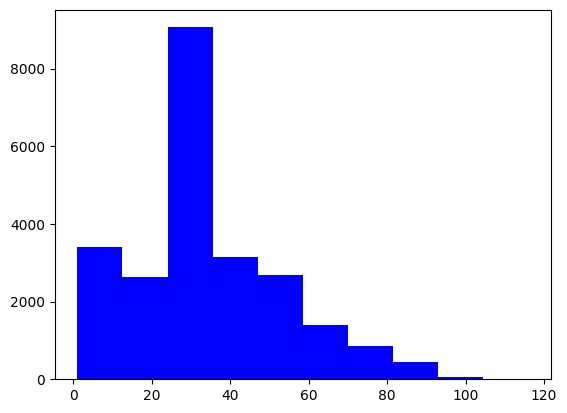

In [8]:
ages = df['age']
nbins = 10
plt.hist(ages,nbins,color='blue',histtype='bar')
plt.show()

In [9]:
df['age'] = df['age']//15
df.head()

,age,gender,race,file
0,1,male,asian,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...
1,1,female,black,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...
2,1,female,indian,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...
3,1,male,white,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...
4,1,female,others,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...


In [17]:
from keras.utils import to_categorical
from PIL import Image
p = np.random.permutation(len(df))

train_up_to = int(len(df) * TRAIN_TEST_SPLIT)      
train_idx = p[:train_up_to]
val_idx = p[train_up_to:]

# converts alias to id
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])

# Now we got train_idx, valid_idx, test_idx
            
def preprocess_image(img_path):   # Used to perform some minor preprocessing on the image before inputting into the network.
    
    im = Image.open(img_path)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0
    
    return im
        
def generate_images(image_idx, is_training, batch_size=16):
    images, ages = [], []

    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            age = person['age']

            # Ensure age is within valid bounds
            if age < 0 or age >= 9:  
                raise ValueError(f"Invalid age value {age}. Age must be in range [0, 9).")

            file = person['file']
            im = preprocess_image(file)

            # Append data
            images.append(im)
            ages.append(to_categorical(age, 9))  # Convert to one-hot encoding

            # Yield batch when ready
            if len(images) >= batch_size:
                yield np.array(images), np.array(ages)
                images, ages = [], []  # Reset for the next batch

        if not is_training:  # Stop if not in training mode
            break


In [25]:
from keras.models import Model
from keras.layers import (
    SeparableConv2D, MaxPooling2D, BatchNormalization,
    SpatialDropout2D, Flatten, Dense, Activation, Dropout, Input
)
from keras.regularizers import l2

# Define default hidden layers
def make_default_hidden_layers(inputs):
    x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

# Build the age branch
def build_age_branch(inputs):   
    x = make_default_hidden_layers(inputs)
    
    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.03))(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(9)(x)
    x = Activation("softmax", name="age_output")(x)  # Only predicting age

    return x

# Assemble the full model
def assemble_model(width, height):
    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    # Only one branch for age
    age_branch = build_age_branch(inputs)

    model = Model(inputs=inputs, outputs=age_branch, name="age_prediction_net")

    return model

# Build the model
model = assemble_model(198, 198)
model.summary()


Model: "age_prediction_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 198, 198, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_14             │ (None, 198, 198, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 198, 198, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 66, 66, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 66, 66, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_15             │ (None, 66, 66, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 66, 66, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 33, 33, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_16             │ (None, 33, 33, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 33, 33, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_17             │ (None, 16, 16, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_8             │ (None, 8, 8, 128)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_18             │ (None, 8, 8, 256)      │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 8, 8, 256)      │             

 Total params: 248,388 (970.27 KB)

 Trainable params: 245,700 (959.77 KB)

 Non-trainable params: 2,688 (10.50 KB)

In [26]:
import math
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def step_decay(epoch):
    initial_lrate = 0.008
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate      

opt = Adam(learning_rate=0.0)  # 0.0 here signifies that the optimizer should follow the LearningRateScheduler
lrate = LearningRateScheduler(step_decay)

# Model compilation - only age loss, no gender loss
model.compile(optimizer=opt, 
              loss={'age_output': 'categorical_crossentropy'},
              metrics={'age_output': 'accuracy'})

callbacks_list = [lrate]


In [28]:
def make_tf_dataset(generator):
    def gen():
        for x, y in generator:
            yield x, y

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, IM_HEIGHT, IM_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 9), dtype=tf.float32)
        )
    ).repeat()  # Repeat the dataset indefinitely


In [29]:
# Test the generator
test_gen = generate_images(train_idx, is_training=True, batch_size=5)

for batch in test_gen:
    images, ages = batch
    print("Images shape:", images.shape)  # Should be (5, height, width, 3)
    print("Ages shape:", ages.shape)      # Should be (5, 5)
    break


Images shape: (5, 198, 198, 3)
Ages shape: (5, 9)


In [30]:
train_gen_tf = make_tf_dataset(generate_images(train_idx, is_training=True, batch_size=32)).repeat()
valid_gen_tf = make_tf_dataset(generate_images(val_idx, is_training=False, batch_size=32)).repeat()


history = model.fit(
    train_gen_tf,
    steps_per_epoch=len(train_idx) // 32,
    epochs=15,
    callbacks=callbacks_list,
    validation_data=None,
    #validation_steps=len(val_idx) // 32
)


Epoch 1/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 474s 898ms/step - accuracy: 0.3144 - loss: 2.9032 - learning_rate: 0.0080
Epoch 2/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 459s 886ms/step - accuracy: 0.4723 - loss: 1.5388 - learning_rate: 0.0080
Epoch 3/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 457s 882ms/step - accuracy: 0.5213 - loss: 1.3631 - learning_rate: 0.0080
Epoch 4/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 458s 884ms/step - accuracy: 0.5466 - loss: 1.2996 - learning_rate: 0.0080
Epoch 5/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 458s 884ms/step - accuracy: 0.5733 - loss: 1.1369 - learning_rate: 0.0040
Epoch 6/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 460s 888ms/step - accuracy: 0.5844 - loss: 1.1018 - learning_rate: 0.0040
Epoch 7/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 455s 879ms/step - accuracy: 0.5961 - loss: 1.0821 - learning_rate: 0.0040
Epoch 8/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 454s 876ms/step - accuracy: 0.5976 - loss: 1.0573 - learning_rate: 0.0040
Epoch 9/15
518/518 ━━━━━━━━━━━━━━━━━━━━ 452s 873ms/step - accuracy: 0.6122 - loss: 1.044

In [32]:
from keras.models import save_model

# Save the trained model
save_model(model, 'age_detection_model.keras')
print("Model saved successfully in Keras format!")


Model saved successfully in Keras format!


In [33]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model('age_detection_model.keras')
print("Model loaded successfully!")


Model loaded successfully!
